In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r'/workspaces/miniconda/PKdata/data-raw/KI20160914/KI20160914.csv')

In [3]:
d1_df = df.loc[df['DAY'] == 1, :]

In [32]:
def plot_subject_levels(df:pd.DataFrame,x = 'TIME' ,y = 'DV', subject = 'SUBJID', ax = None):
    if ax is None:
        fig, ax = plt.subplots(1)
    for c in df.columns:
        df.loc[df[c] == '.', c] = pd.NA
    df[y] = df[y].astype(pd.Float32Dtype())
    df[x] = df[x].astype(pd.Float32Dtype())
    sns.lineplot(data = df, x = x, y = y, hue = subject, ax = ax)
        

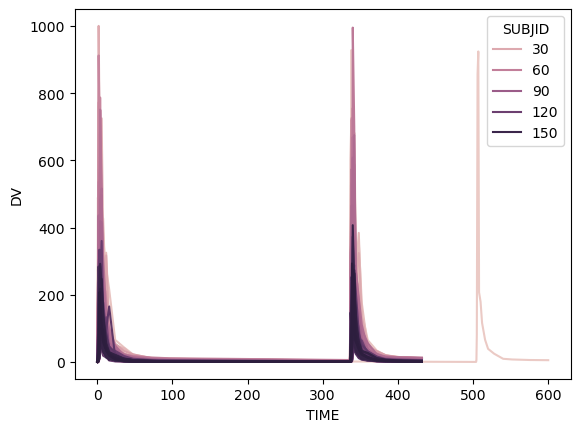

In [5]:
plot_subject_levels(df)

In [6]:
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm
from utils import one_compartment_model, objective_function
import_funcs = False
if import_funcs:
    def one_compartment_model(t, y, k, Vd, dose):
        """
        Defines the differential equation for a one-compartment pharmacokinetic model.

        This function calculates the rate of change of drug concentration in the central 
        compartment over time.

        Args:
        t (float): Time point (not used in this specific model, but required by solve_ivp).
        y (list): Current drug concentration in the central compartment.
        k (float): Elimination rate constant.
        Vd (float): Volume of distribution.
        dose (float): Administered drug dose (not used in this model, as it assumes 
                        intravenous bolus administration where the initial concentration 
                        is directly given).

        Returns:
        float: The rate of change of drug concentration (dC/dt).
        """
        C = y[0]  # Extract concentration from the state vector
        dCdt = -(k/Vd) * C  # Calculate the rate of change
        return dCdt

    def objective_function(params, data, subject_id = 'SUBJID', dose = 'DOSR', time = 'TIME', conc_at_time = 'DV'):
        """
        Calculates the sum of squared errors (SSE) between observed and predicted drug 
        concentrations.

        This function simulates drug concentrations for each subject in the dataset using 
        a one-compartment model and compares the predictions to the actual observations. 
        The SSE is used as a measure of the goodness of fit for the given model parameters.

        Args:
            params (tuple): Tuple containing the model parameters (k, Vd).
            data (DataFrame): Pandas DataFrame containing the pharmacokinetic data, with columns
                            for 'SUBJID', 'DOSR', 'DV' (observed concentration), and 'TIME'.

        Returns:
            float: The sum of squared errors (SSE).
        """
        k, Vd = params  # Unpack parameters
        #Vd = Vd + 1e-6 if Vd == 0 else Vd  # Add a small value to Vd to avoid division by zero (commented out)
        predictions = []
        for subject in tqdm(data[subject_id].unique()):  # Loop through each subject in the dataset
            d = data.loc[data[subject_id] == subject, dose]  # Extract dose information for the subject
            d = d.drop_duplicates()  # Ensure only one dose value is used
            dose = d.values[0]  # Get the dose value
            subject_data = data[data[subject_id] == subject]  # Get data for the current subject
            initial_conc = subject_data[conc_at_time].values[0]  # Get the initial concentration

            # Solve the differential equation for the current subject
            sol = solve_ivp(one_compartment_model, [subject_data[time].min(), subject_data[time].max()], [initial_conc], 
                            t_eval=subject_data[time], args=(k, Vd, dose))
            
            predictions.extend(sol.y[0])  # Add the predictions for this subject to the list

        residuals = data[conc_at_time] - predictions  # Calculate the difference between observed and predicted values
        sse = np.sum(residuals**2)  # Calculate the sum of squared errors
        return sse

In [7]:
#prepare day 1 data
opt_df = df.dropna(subset = 'DV').copy()
opt_df['DV'] = opt_df['DV'].astype(pd.Float32Dtype())
opt_df = opt_df.loc[opt_df['DAY'] == 1, :]

#Within day 1 data, per subject identify the max concentration
#Drop time points occuring before the max, and set the time at that max conc to t=0
dfs = []
for c in opt_df['SUBJID'].drop_duplicates():
    work_df = opt_df.loc[opt_df['SUBJID'] == c, :].reset_index(drop = True)
    max_idx = work_df.loc[work_df['DV'] == work_df['DV'].max(), :].index[0]
    work_df = work_df.iloc[max_idx:, :]
    work_df['TIME'] = work_df['TIME'] - work_df['TIME'].min()
    dfs.append(work_df.copy())
work_df = pd.concat(dfs)

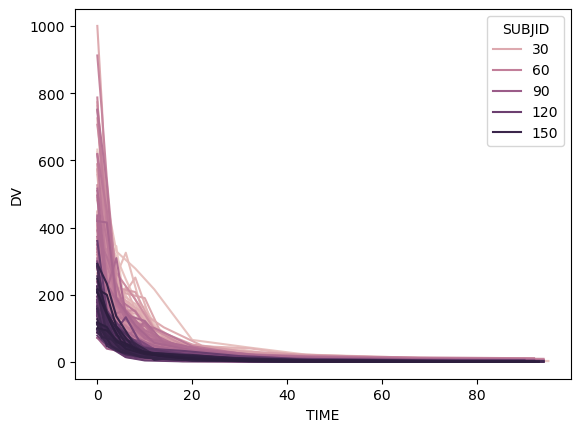

In [8]:
#plot the prepared data
plot_subject_levels(work_df)
#sns.lineplot(data = work_df, x = 'TIME', y = 'DV', hue = 'SUBJID')

In [9]:
import numpy as np
from scipy.optimize import minimize
from joblib import dump, load
import os
from functools import partial
from utils import optimize_with_checkpoint_joblib


if import_funcs:
    def optimize_with_checkpoint_joblib(func, x0, n_checkpoint, checkpoint_filename, *args, **kwargs):
        """
        Optimizes a function using scipy.optimize.minimize() with checkpointing every n iterations,
        using joblib for saving and loading checkpoints.

        Args:
            func: The objective function to be minimized.
            x0: The initial guess.
            n_checkpoint: The number of iterations between checkpoints.
            checkpoint_filename: The filename to save checkpoints to.
            *args: Additional positional arguments to be passed to minimize().
            **kwargs: Additional keyword arguments to be passed to minimize().

        Returns:
            The optimization result from scipy.optimize.minimize().
        """

        iteration = 0
        
        # Try to load a previous checkpoint if it exists
        try:
            checkpoint = load(checkpoint_filename)
            x0 = checkpoint['x']
            iteration = checkpoint['iteration']
            print(f"Resuming optimization from iteration {iteration}")
        except FileNotFoundError:
            print("No checkpoint found, starting from initial guess.")
        except Exception as e:
            print(f"Error loading checkpoint: {e}, starting from initial guess.")

        def callback_with_checkpoint(xk, checkpoint_filename):
            nonlocal iteration
            iteration += 1
            print(iteration)
            if iteration % n_checkpoint == 0:
                checkpoint = {
                    'x': xk,
                    'iteration': iteration
                }
                checkpoint_filename = checkpoint_filename.replace('.jb', f'_{iteration}.jb')
                dump(checkpoint, checkpoint_filename)
                print(f"Iteration {iteration}: Checkpoint saved to {checkpoint_filename}")
            print('no log')

        # Ensure callback is not already in kwargs
        if 'callback' not in kwargs:
            kwargs['callback'] = partial(callback_with_checkpoint, checkpoint_filename = checkpoint_filename)
        else:
            # If callback exists, combine it with the existing one
            user_callback = kwargs['callback']
            def combined_callback(xk):
                callback_with_checkpoint(xk, checkpoint_filename)
                user_callback(xk)

            kwargs['callback'] = combined_callback
        
        result = minimize(func, x0, *args, **kwargs)
        
        # Remove checkpoint file at end.
        #try:
        #    os.remove(checkpoint_filename)
        #except:
        #    pass

        return result

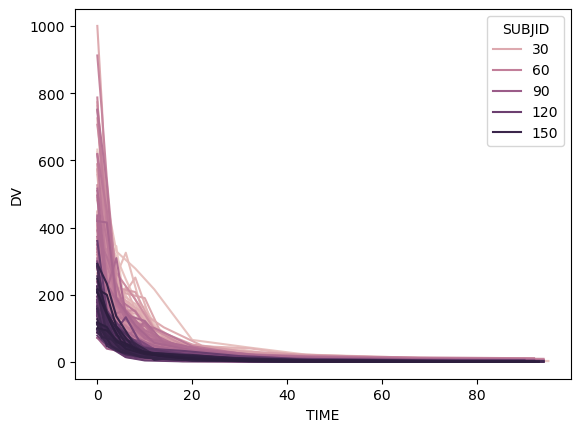

In [39]:
from sklearn.preprocessing import RobustScaler
#Scale the dose and y variables -- scaling the y is probably not necessary

scale_df = work_df.copy()
#scale_df[['DV']] = RobustScaler().fit_transform(scale_df[['DV']])
scale_df['DOSR'] = scale_df['DOSR'] / 100
plot_subject_levels(scale_df)

In [40]:
from scipy.optimize import minimize


# opt_df = opt_df.loc[opt_df['TIME'] >= 1, :].copy()
initial_guess = [0.1, 4.0]  # Initial guesses for k and Vd
result = optimize_with_checkpoint_joblib(objective_function, initial_guess, n_checkpoint=5, checkpoint_filename='check.jb', args=(
    # Bounds added to prevent negative values
    scale_df,), bounds=[(1e-6, None), (1e-6, None)])
# result = minimize(objective_function, initial_guess, args=(work_df,), bounds=[(1e-6,None),(1e-6,None)])

No checkpoint found, starting from initial guess.


100%|██████████| 159/159 [00:00<00:00, 219.08it/s]


1
no log


100%|██████████| 159/159 [00:00<00:00, 250.43it/s]


2
no log


100%|██████████| 159/159 [00:00<00:00, 250.56it/s]


3
no log


100%|██████████| 159/159 [00:00<00:00, 258.02it/s]


4
no log


100%|██████████| 159/159 [00:00<00:00, 219.12it/s]


5
Iteration 5: Checkpoint saved to check_5.jb
no log


100%|██████████| 159/159 [00:00<00:00, 258.87it/s]

6
no log


In [41]:
def generate_ivp_predictions(optimized_result, df, subject_id_c = 'SUBJID', dose_c = 'DOSR', time_c = 'TIME', conc_at_time_c = 'DV'):
    predictions = {}
    est_k, est_vd = result.x
    data = df.copy()
    for subject in data[subject_id_c].unique():
        d = data.loc[data[subject_id_c] == subject, dose_c]
        d =  d.drop_duplicates()
        dose = d.values[0]
        subject_data = data[data[subject_id_c] == subject]

        initial_conc = subject_data[conc_at_time_c].values[0]
        #the initial value is initial_conc in this setup. If absorbtion was being modeled it would be [dose/est_vd]
        sol = solve_ivp(one_compartment_model, [subject_data[time_c].min(), subject_data[time_c].max()], [initial_conc],
                        t_eval=subject_data[time_c], args=(est_k, est_vd, dose))
        predictions[subject] = sol
    return predictions

In [42]:
predictions = generate_ivp_predictions(result, scale_df)

In [52]:
def stack_ivp_predictions(ivp_predictions, time_c = 'TIME', pred_DV_c = 'Pred_DV', subject_id_c = 'SUBJID'):
    dfs = []
    for subject in ivp_predictions:
        loop_df = pd.DataFrame()
        time_vector = ivp_predictions[subject].t
        preds_vector = ivp_predictions[subject].y[0]
        loop_df[time_c] = time_vector
        loop_df[pred_DV_c] = preds_vector
        loop_df[subject_id_c] = subject
        dfs.append(loop_df)
    return pd.concat(dfs)

def merge_ivp_predictions(df, ivp_predictions, time_c = 'TIME', pred_DV_c = 'Pred_DV', subject_id_c = 'SUBJID'):
    df = df.copy()
    result_df = stack_ivp_predictions(ivp_predictions, time_c, pred_DV_c, subject_id_c)
    merge_df = df.merge(result_df, how = 'left', on = [subject_id_c, time_c])
    return merge_df
    

In [54]:
merge_df = merge_ivp_predictions(scale_df, predictions)
merge_df.head()

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT,Pred_DV
0,1.0,1.0,1.0,0.0,1.0,3.0,NaN,275.0,0.0,B,1.0,26.0,84.0,275.000000
1,1.0,1.0,1.0,1.0,2.0,3.0,NaN,244.0,0.0,B,1.0,26.0,84.0,218.116851
2,1.0,1.0,1.0,2.0,3.0,3.0,NaN,151.0,0.0,B,1.0,26.0,84.0,172.975033
3,1.0,1.0,1.0,3.0,4.0,3.0,NaN,130.0,0.0,B,1.0,26.0,84.0,137.127345
4,1.0,1.0,1.0,5.0,6.0,3.0,NaN,147.0,0.0,B,1.0,26.0,84.0,86.359454


In [45]:
merge_df['PRED_DV_diff_%'] = 100 * ((merge_df['Pred_DV'] - merge_df['DV'])/ ((merge_df['Pred_DV'] + merge_df['DV']) / 2))
merge_df['log_PRED_DV_diff_%'] = np.log(np.abs(merge_df['PRED_DV_diff_%']) + 1e-6)

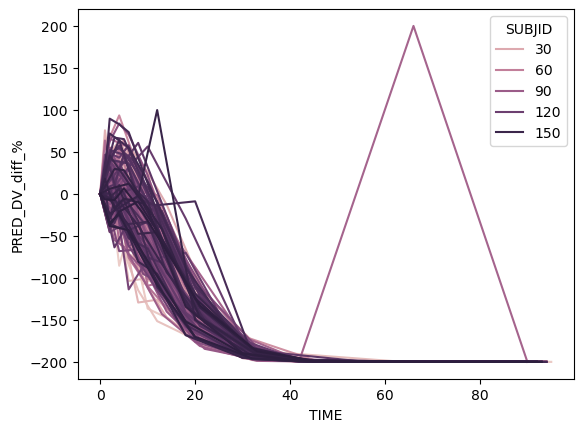

In [50]:
plot_subject_levels(merge_df, x = 'TIME', y = 'PRED_DV_diff_%')

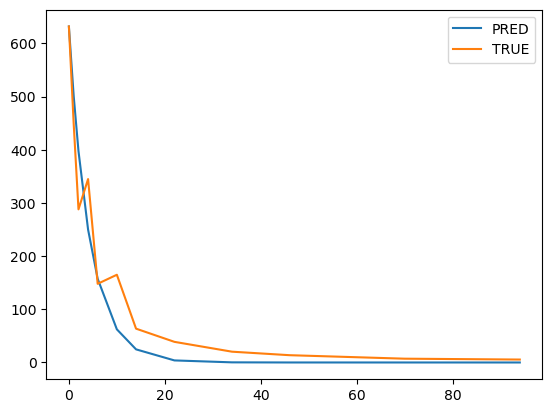

In [49]:
import matplotlib.pyplot as plt
subject_id = 5
plot_df = scale_df.loc[scale_df['SUBJID'] == subject_id, :]
plt.plot(predictions[subject_id].t, predictions[subject_id].y[0], label = 'PRED')
plt.plot(predictions[subject_id].t, plot_df['DV'].values, label = 'TRUE')
plt.legend()